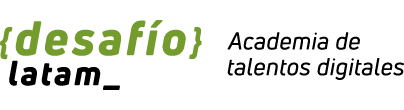

#<center><font color="green">Solución Desafío - Segmentación de clientes </font></center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

Se describirán sugerencias para los pasos de análisis de los datos, que pueden variar entre los estudiantes.

- Defninimos una función para analizar los datos



In [2]:
def data_quality_analysis(df):
    # Crear un nuevo dataframe para almacenar los resultados
    result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores únicos', 'Valores faltantes'])

    # Obtener información general del dataframe
    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().sum() for column in columns]

    # Llenar el nuevo dataframe con los resultados
    result_df['Columna'] = columns
    result_df['tipo'] = data_types
    result_df['Valores únicos'] = unique_values
    result_df['Valores faltantes'] = missing_values

    return result_df.set_index('Columna')

- Leemos y analizamos los datos

In [3]:
data = pd.read_excel('Retail_Invoices.xlsx')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date
data.InvoiceDate.min(), data.InvoiceDate.max()

(datetime.date(2010, 12, 1), datetime.date(2011, 12, 9))

In [4]:
# Ejemplo de uso de la función con el dataframe 'df'
calidad = data_quality_analysis(data)
print(calidad)

            Tipo de dato  Valores únicos  Valores faltantes     tipo
Columna                                                             
InvoiceNo            NaN           22190                  0   object
InvoiceDate          NaN             305                  0   object
CustomerID           NaN            4372                  0    int64
Quantity             NaN            1594                  0    int64
price_total          NaN           16534                  0  float64
StockCode            NaN             199                  0    int64


1. No se observan nulos en un inicio.
2. Se observa que tanto Quantity y price_total tienen valores negativos, que deberíasn ser borrados, porque no se puede comprar un número negativo de elementos.
3. Se observan 4 valores con price_total igual a 0.
4. Se observa que no hay InvoiceNo repetidos, ya que la frecuencia máxima es 1.
5. Hay datos entre Diciembre del 2010 y Diciembre del 2011.

In [5]:
mask = (data.Quantity>0) & (data.price_total>0)
data = data.loc[mask]
data.shape

(18532, 6)

In [6]:
calidad = data_quality_analysis(data)
calidad

Tipo de dato  Valores únicos  Valores faltantes     tipo
Columna                                                             
InvoiceNo            NaN           18532                  0   object
InvoiceDate          NaN             305                  0   object
CustomerID           NaN            4338                  0    int64
Quantity             NaN            1394                  0    int64
price_total          NaN           14927                  0  float64
StockCode            NaN             199                  0    int64

1. Existen valores muy alejados en Quantity y StockCode. Se observa que hay cantidades de 80.995, cierto el limite superior de outliers 617.
2. Hay que ver la frecuencia de los valores mayores a 617 y cortar lo necesario

- Análisis Exploratorio de los datos

In [7]:
cols = ['CustomerID', 'Quantity', 'price_total', 'StockCode']

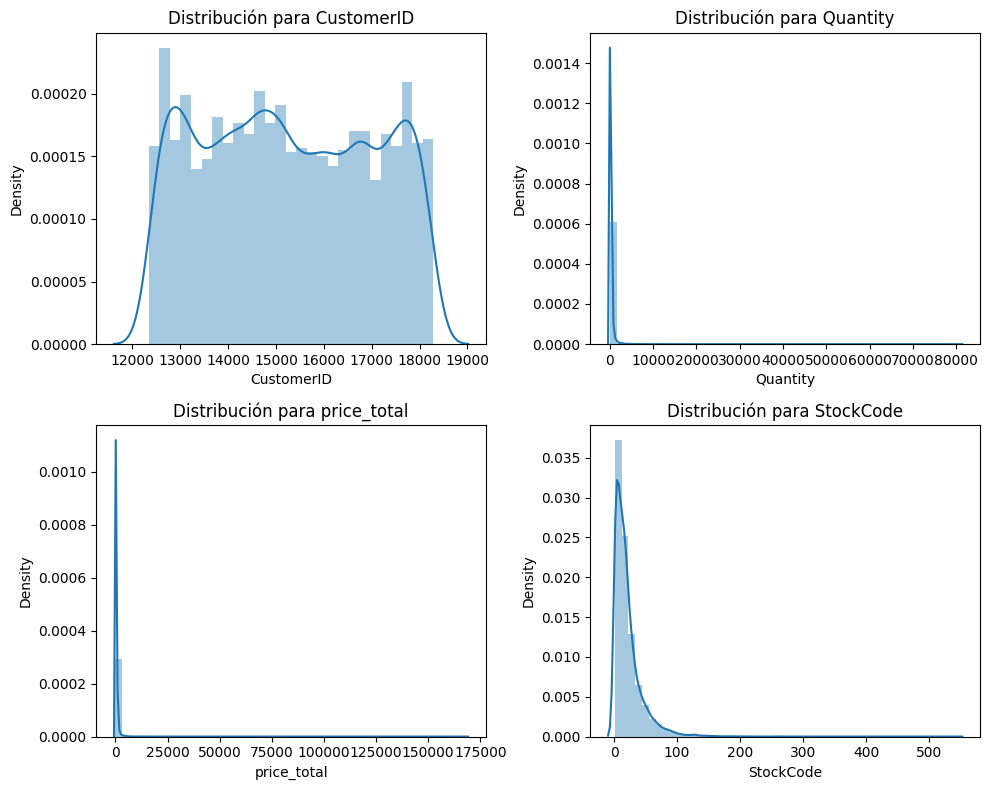

In [ ]:
plt.figure(figsize=(10, 8))
for n, i in enumerate(cols):
    plt.subplot(2, 2, n + 1)
    if calidad.loc[i, 'tipo']=='object':
        sns.countplot(y= data[i], order = data[i].value_counts().index)
        plt.title('Frecuencias para {}'.format(i))
        plt.tight_layout()
    else:
        sns.distplot(data[i])
        plt.title('Distribución para {}'.format(i))
        plt.tight_layout()

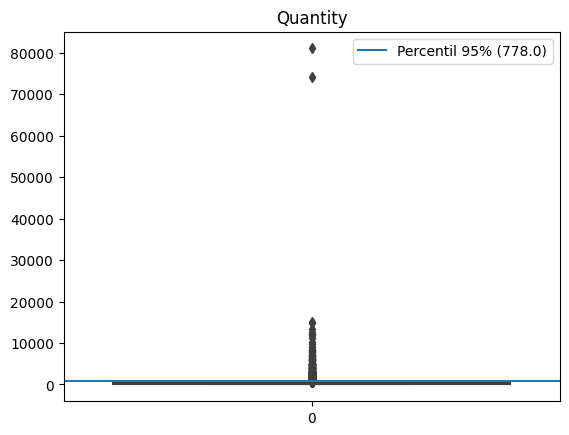

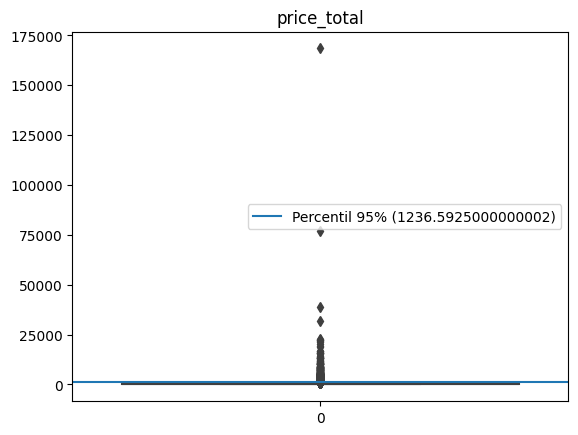

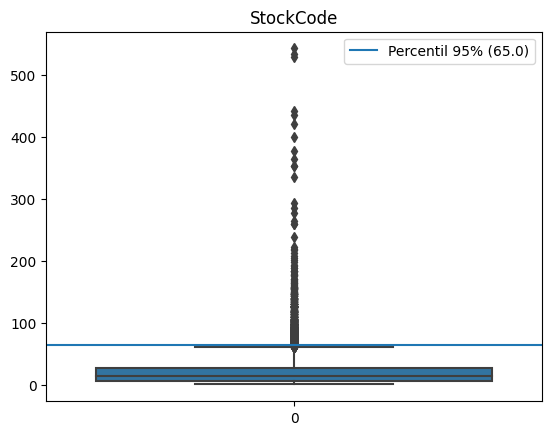

In [8]:
for i in ['Quantity', 'price_total', 'StockCode']:
    sns.boxplot(data[i])
    quant_95 = data[i].quantile([0.95]).values[0]
    plt.axhline(quant_95, label=f'Percentil 95% ({quant_95})')
    plt.title(i)
    plt.legend()
    plt.xlabel('')
    plt.show()

In [9]:
mask = (data.Quantity<data['Quantity'].quantile([0.95]).values[0]) & (data.price_total<data['price_total'].quantile([0.95]).values[0])
data_ = data.loc[mask]
data_['InvoiceDate'] = pd.to_datetime(data_['InvoiceDate'])
data_.shape

(17337, 6)

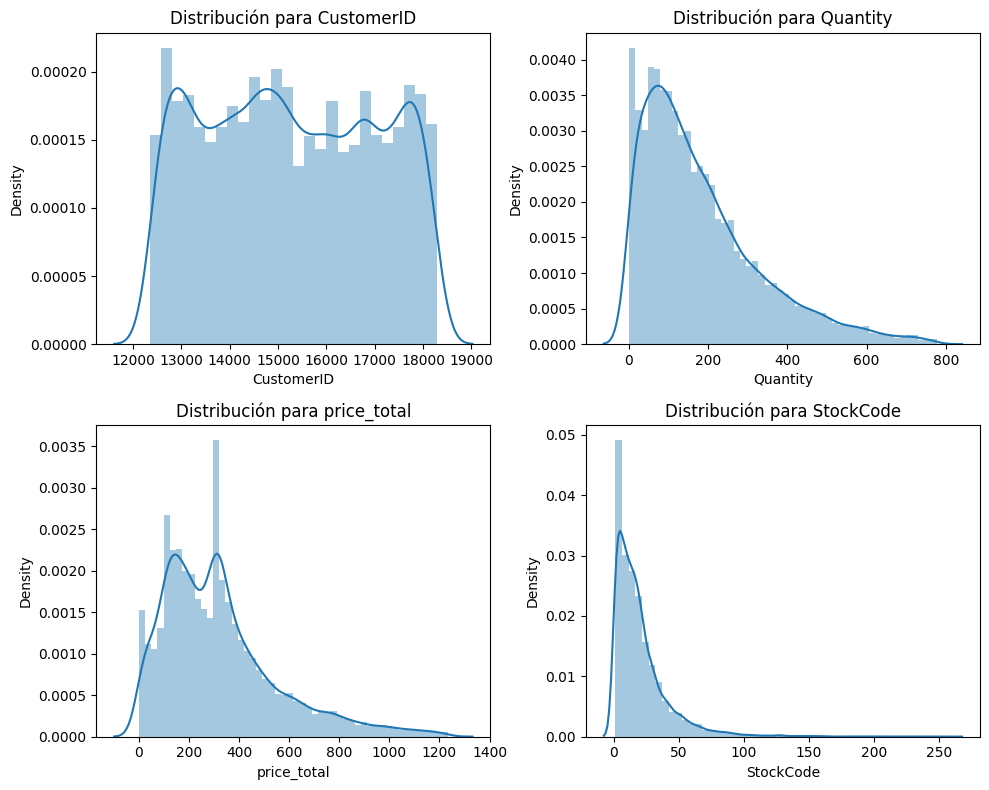

In [10]:
plt.figure(figsize=(10, 8))
for n, i in enumerate(cols):
    plt.subplot(2, 2, n + 1)
    if calidad.loc[i, 'tipo']=='object':
        sns.countplot(y= data_[i], order = data_[i].value_counts().index)
        plt.title('Frecuencias para {}'.format(i))
        plt.tight_layout()
    else:
        sns.distplot(data_[i])
        plt.title('Distribución para {}'.format(i))
        plt.tight_layout()

<Axes: >

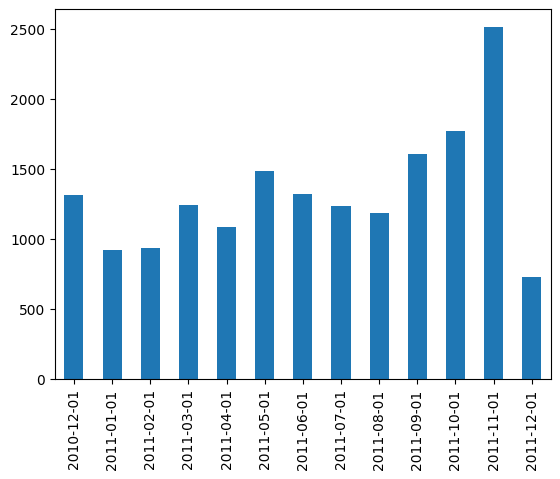

In [11]:
data_['ano_mes'] = [i.replace(day=1) for i in pd.to_datetime(data_['InvoiceDate'])]

data_.ano_mes.dt.date.value_counts().sort_index().plot(kind='bar')

Con esta información uno observa que Diciembre 2011 no esta completo, además que vimos que solo hay data hasta el 9 de diciemrbe del año 2011. Se procura hacer el análisis con una ventana de 12 meses entre Diciembre 2019 y Noviembre 2011.

Se ve una tendencia al aumento de boletas en el año 2011, con un peak en los últimos 3 meses.

<Axes: >

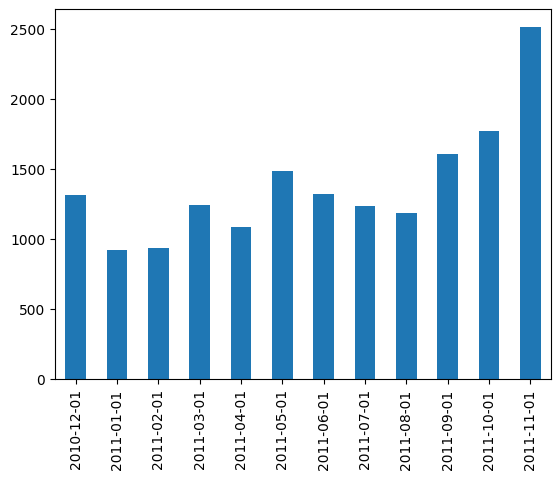

In [12]:
data_ = data_.loc[data_.InvoiceDate<'2011-12-01']
data_.ano_mes.dt.date.value_counts().sort_index().plot(kind='bar')

Text(0.5, 1.0, 'Correlaciones')

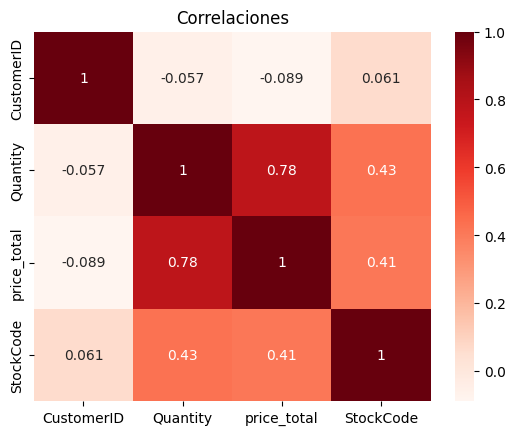

In [13]:
# Ojo: La correlacion de pearson es una medida de correlacion lineal entre variables númericas, por lo que las variables binarias no estaría 100%, pero de todas formas da buenos input en el análisis
sns.heatmap(data_.corr(), cmap='Reds', annot=True)
plt.title('Correlaciones')

Se observa lo siguiente.
1. Claramente hay una correlacion fuerte entre numero de boleta y la fecha, ya que esta va creciendo en base hay más boletas y eso se correlaciona con las fechas.
2. La cantidad de productos se correlaciona fuertemente con el precio total de la boleta, pero no tanto asi con la cantidad de productos distintos.

- Variables de Segmentación

In [16]:
data_.head(2)

InvoiceNo InvoiceDate  CustomerID  Quantity  price_total  StockCode  \
0    536365  2010-12-01       17850        40       139.12          7   
1    536366  2010-12-01       17850        12        22.20          2   

     ano_mes  
0 2010-12-01  
1 2010-12-01

In [17]:
data_seg = data_.groupby('CustomerID').agg(
            ult_compra = ('InvoiceDate', 'max'),
            frecuencia = ('InvoiceNo', 'count'),
            cantidad_promedio = ('Quantity', 'mean'),
            cantidad_total = ('Quantity', 'sum'),
            monto_promedio = ('price_total', 'mean'),
            monto_total = ('price_total', 'sum'),
            articulos_distintos_promedio = ('StockCode', 'mean'),
            distintos_meses = ('ano_mes', 'nunique')
        )
data_seg

ult_compra  frecuencia  cantidad_promedio  cantidad_total  \
CustomerID                                                             
12347      2011-08-02           5         318.000000            1590   
12348      2011-09-25           3         362.333333            1087   
12350      2011-02-02           1         197.000000             197   
12352      2011-11-03           8          67.000000             536   
12353      2011-05-19           1          20.000000              20   
...               ...         ...                ...             ...   
18280      2011-03-07           1          45.000000              45   
18281      2011-06-12           1          54.000000              54   
18282      2011-08-05           1          75.000000              75   
18283      2011-11-30          15          83.666667            1255   
18287      2011-10-28           2         298.000000             596   

            monto_promedio  monto_total  articulos_distintos_promedio  \
CustomerID                                                              
12347              558.172      2790.86                     24.800000   
12348              301.480       904.44                      4.666667   
12350              334.400       334.40                     17.000000   
12352              313.255      2506.04                     10.625000   
12353               89.000        89.00                      4.000000   
...                    ...          ...                           ...   
18280              180.600       180.60                     10.000000   
18281               80.820        80.82                      7.000000   
18282              100.210       100.21                      7.000000   
18283              125.792      1886.88                     47.066667   
18287              417.980       835.96                     16.000000   

            distintos_meses  
CustomerID                   
12347                     5  
12348                     3  
12350                     1  
12352                     4  
12353                     1  
...                     ...  
18280                     1  
18281                     1  
18282                     1  
18283                     9  
18287                     2  

[4211 rows x 8 columns]

In [18]:
## Se toma el supuesto de un análisis a principio del Diciembre 2011, por lo que la recencia se marca desde ese día
data_seg['recencia_dias'] = (pd.to_datetime('2011-12-01') - data_seg['ult_compra']).dt.days

- Análisis Exploratorio y Transformaciones

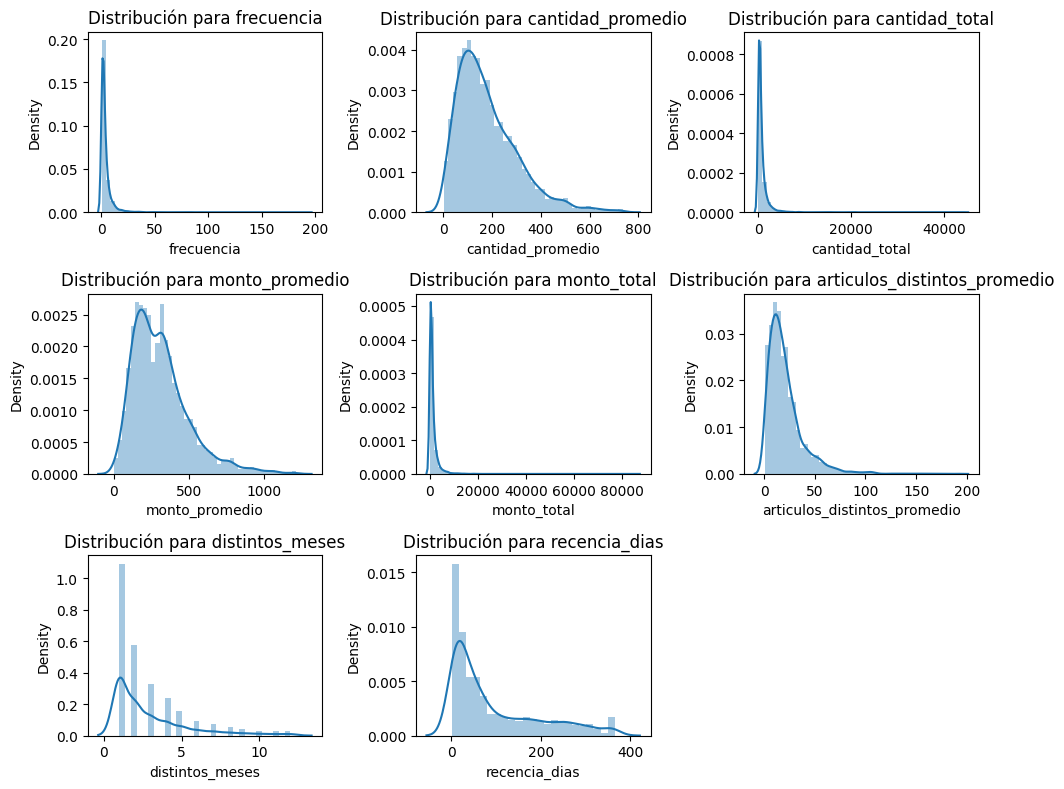

In [19]:
plt.figure(figsize=(10, 8))
for n, i in enumerate(data_seg.columns[1:]):
    plt.subplot(3, 3, n + 1)
    sns.distplot(data_seg[i])
    plt.title('Distribución para {}'.format(i))
    plt.tight_layout()

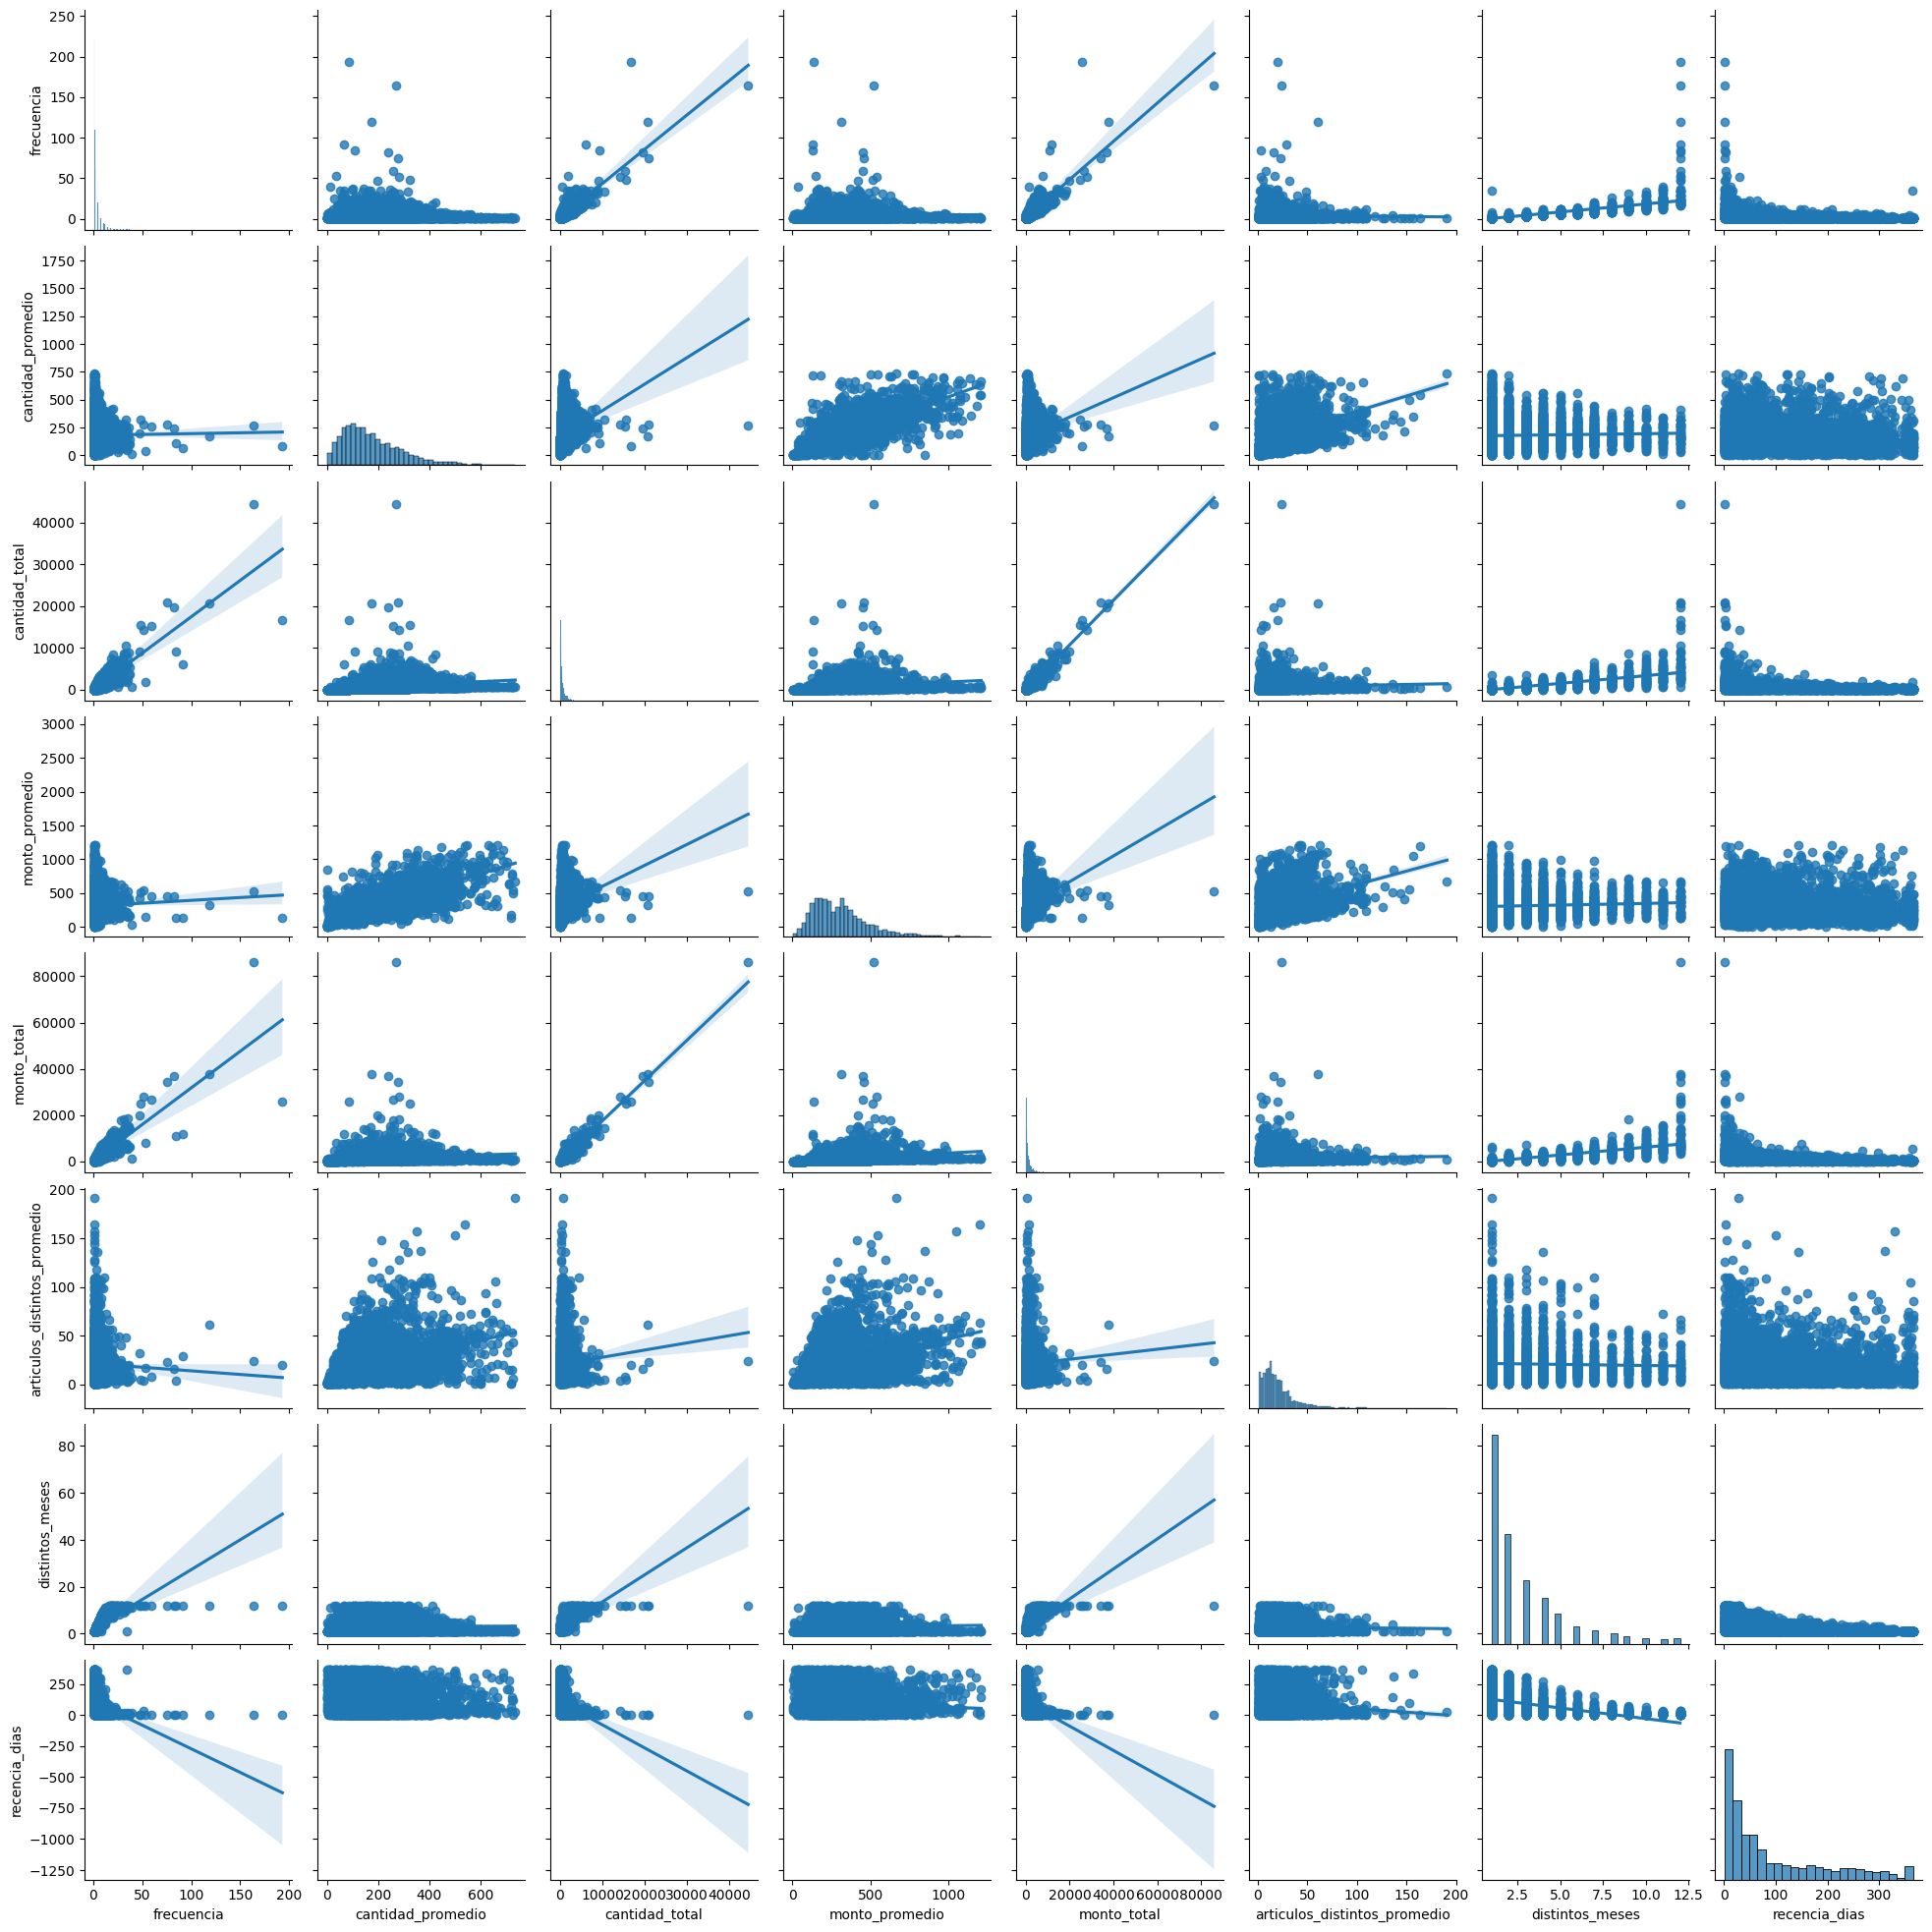

In [20]:
sns.pairplot(data_seg, kind='reg')

Text(0.5, 1.0, 'Correlaciones')

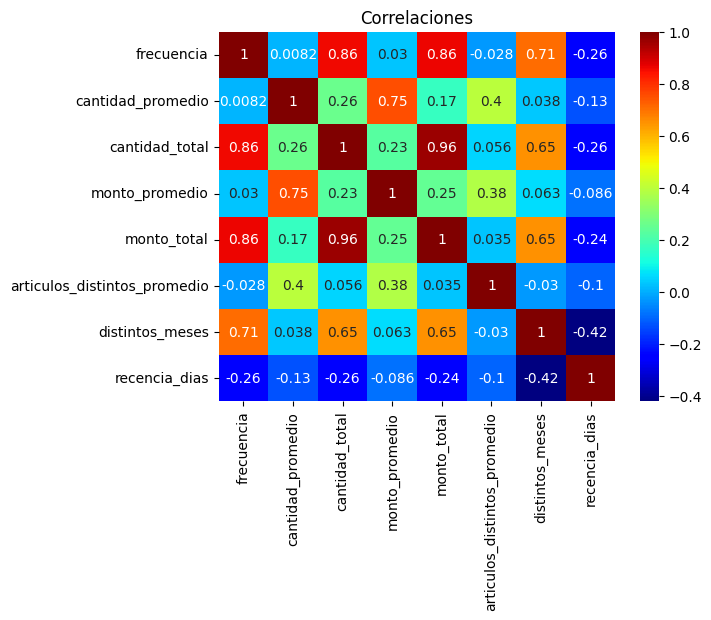

In [21]:
# Ojo: La correlacion de pearson es una medida de correlacion lineal entre variables númericas, por lo que las variables binarias no estaría 100%, pero de todas formas da buenos input en el análisis
sns.heatmap(data_seg.corr(), cmap='jet', annot=True)
plt.title('Correlaciones')

# ROJOS Y AZULES FUERETS EN DIRECCION PROPORCIONAL O INVERSA RESPECTIVAMENTE

In [22]:
X = data_seg.loc[:, ['frecuencia', 'monto_promedio', 'recencia_dias']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
data_clus = pd.DataFrame(X_scaled, columns = ['var1', 'var2', 'var3'], index=X.index)
data_clus

var1      var2      var3
CustomerID                              
12347       0.156436  1.309476  0.279692
12348      -0.139765 -0.059698 -0.264114
12350      -0.435966  0.115895  2.102447
12352       0.600736  0.003109 -0.656862
12353      -0.435966 -1.193049  1.034977
...              ...       ...       ...
18280      -0.435966 -0.704462  1.770121
18281      -0.435966 -1.236680  0.793286
18282      -0.435966 -1.133256  0.249480
18283       1.637439 -0.996803 -0.928765
18287      -0.287865  0.561703 -0.596439

[4211 rows x 3 columns]

- Clustering

- Metodo del codo

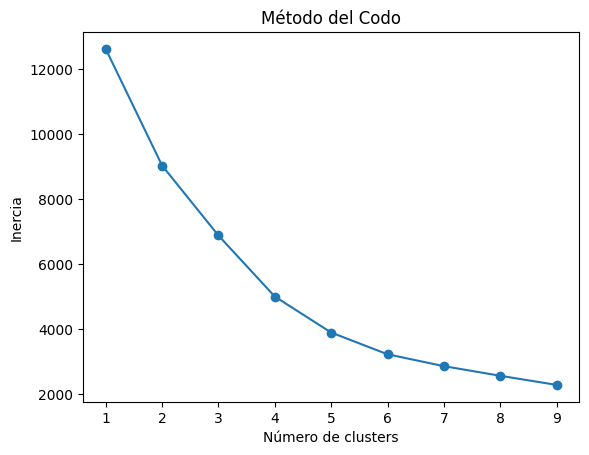

In [24]:
# Realizar el método del codo para encontrar el número óptimo de clusters
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_clus)
    inertia.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

Se observa que 3 y 5 son buenos propectos para un numero de cluster óptimo

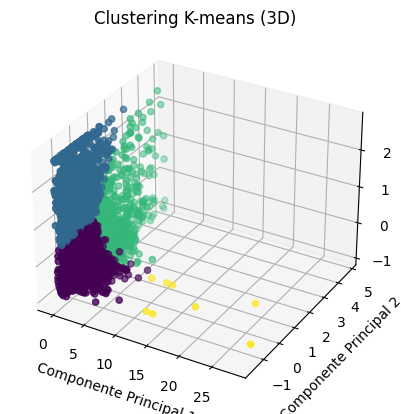

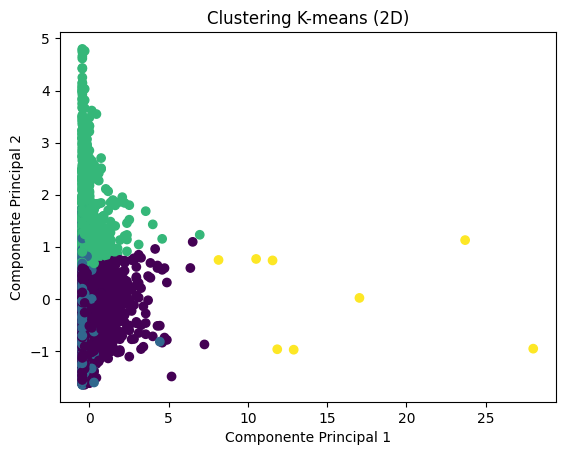

In [25]:
# Aplicar K-means con el número óptimo de clusters encontrado
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(data_clus)

#GUARDAR LABELS
X['label_kmeans']= kmeans_labels

# Graficar resultados en 3D  ESTO ES COMPLETAMENTE OPCIONAL, YA QUE NO SE ABORDÓ EN CLASES. SOLO SI LO ABORDARAN COMPLEMENTARIAMENTE O EN TUTORÍA
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], data_clus.iloc[:, 2], c=kmeans_labels)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Característica 3')
ax.set_title('Clustering K-means (3D)')
plt.show()


# Graficar resultados en 2D
plt.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], c=kmeans_labels)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clustering K-means (2D)')
plt.show()

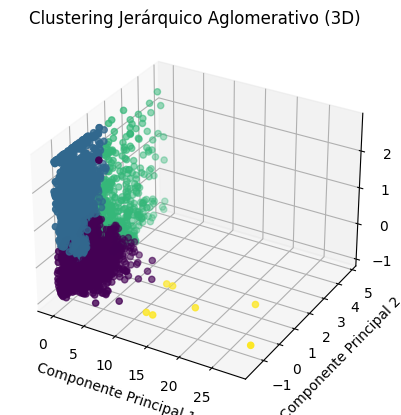

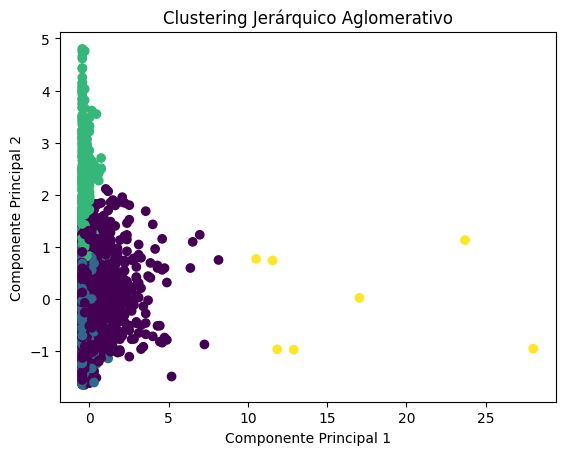

In [26]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(data_clus)
X['label_agg']= agg_labels


# Graficar resultados en 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], data_clus.iloc[:, 2], c=agg_labels)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Característica 3')
ax.set_title('Clustering Jerárquico Aglomerativo (3D)')
plt.show()


# Graficar resultados en 2D
plt.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], c=agg_labels)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clustering Jerárquico Aglomerativo')
plt.show()

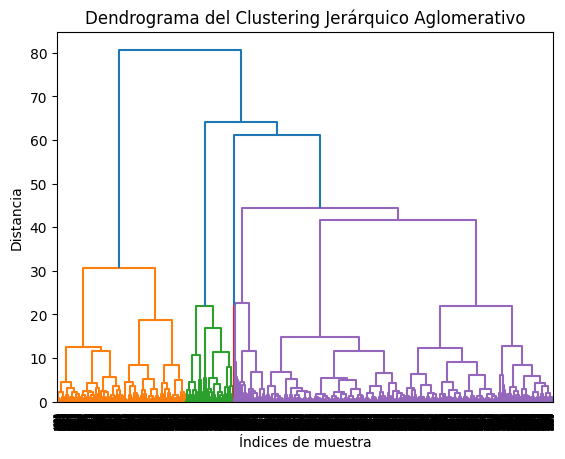

In [27]:
# Calcular la matriz de distancias
distances = pdist(data_clus)

# Calcular la matriz de enlace
linkage_matrix = linkage(distances, method='ward')

# Generar dendrograma
dendrogram(linkage_matrix)

# Graficar dendrograma
plt.xlabel('Índices de muestra')
plt.ylabel('Distancia')
plt.title('Dendrograma del Clustering Jerárquico Aglomerativo')
plt.show()

- Validación de Clusters

In [28]:
for labels_i in [kmeans_labels, agg_labels]:
    # Calcular el índice de David-Bouldin
    db_index = davies_bouldin_score(data_clus, labels_i)
    # Calcular el coeficiente de Silhouette
    silhouette_avg = silhouette_score(data_clus, labels_i)

    print(f"Índice de David-Bouldin: {db_index}")
    print(f"Coeficiente de Silhouette: {silhouette_avg}")
    print('*'*100)

Índice de David-Bouldin: 0.802571379231881
Coeficiente de Silhouette: 0.4064023466017712
****************************************************************************************************
Índice de David-Bouldin: 0.7745432833323656
Coeficiente de Silhouette: 0.38652279703298065
****************************************************************************************************


In [29]:
resumen = X.reset_index().groupby('label_kmeans').agg({
    'CustomerID': 'count',
    'frecuencia' : ['mean', 'std'],
    'monto_promedio' : ['mean', 'std'],
    'recencia_dias' : ['mean', 'std'],
})

resumen.index = ['Compradores recurrentes', 'Compradores ocasionales - unicos', 'Compradores de montos altos', 'outliers']
resumen

CustomerID  frecuencia             \
                                      count        mean        std   
Compradores recurrentes                2401    4.688463   5.246148   
Compradores ocasionales - unicos       1010    1.595050   1.483098   
Compradores de montos altos             792    3.626263   4.203029   
outliers                                  8  108.375000  47.074220   

                                 monto_promedio             recencia_dias  \
                                           mean         std          mean   
Compradores recurrentes              249.663814   99.995656     38.137859   
Compradores ocasionales - unicos     228.875244  125.484804    243.037624   
Compradores de montos altos          610.430474  163.243131     70.106061   
outliers                             324.330934  169.694511      2.000000   

                                             
                                        std  
Compradores recurrentes           33.719686  
Compradores ocasionales - unicos  66.630994  
Compradores de montos altos       69.946766  
outliers                           0.755929